## Table of Contents
- [Part I - Gather, Assess and Clean the Data](#partI)
    - [Gather](#Gather)
    - [Assess](#Assess)
        - [Issues with The WeRateDogs Twitter Archive dataframe](#issuesI)
        - [Issues with The Tweet Image Predictions dataframe](#issuesII)
        - [Issues with The Tweet Data dataframe](#issuesIII)
    - [Clean](#Clean)
        - [Summary](#Summary)
        - [Addressing the Issues](#Address)
- [Part II - Analysis and Insight](#partII)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import tweepy
from timeit import default_timer as timer
from PIL import Image
from wordcloud import WordCloud
import seaborn as sns
from scipy import stats
%matplotlib inline

<a id='partI'></a>
## Part I - Gather, Assess and Clean the Data

<a id='Gather'></a>
### Gather

In [2]:
url_im_pred = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url_im_pred)
r.status_code

200

In [3]:
r.encoding

'utf-8'

In [4]:
with open('image_predictions.tsv', 'w') as file:
    file.write(r.text)

In [5]:
consumer_key = 'YOUR_KEY'
consumer_secret = 'YOUR_SECRET'
access_token = 'YOUR_TOKEN'
access_secret = 'YOUR_SECRET'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [6]:
# get tweet IDs from the archive
tweet_ids = twtarch['tweet_id'].values
tot = len(tweet_ids)

# query twitter's API for JSON data for each tweet ID in the twitter archive
count = 0
fails_dict = {}

# start timer
start = timer()
# save each tweet's returned JSON as a new line in the specified txt file
with open('tweet_json.txt', 'w') as outfile:
    for tweet_id in tweet_ids:
        count += 1
        print('{} of {}: {}'.format(str(count), str(tot), str(tweet_id)))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
# end timer
end = timer()

# print duration and error output ids
print(end - start)
print(fails_dict)

<a id='Assess'></a>
### Assess

In [7]:
twtarch = pd.read_csv('twitter-archive-enhanced.csv')

In [8]:
imgpred = pd.read_csv('image_predictions.tsv', sep='\t')

In [9]:
# pretty print to visualise locations of the desired entities in json
with open('tweet_json.txt') as json_file:
    parsed = json.loads(json_file.readline())
    print(json.dumps(parsed, indent=4))

{
    "created_at": "Tue Aug 01 16:23:56 +0000 2017",
    "id": 892420643555336193,
    "id_str": "892420643555336193",
    "full_text": "This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU",
    "truncated": false,
    "display_text_range": [
        0,
        85
    ],
    "entities": {
        "hashtags": [],
        "symbols": [],
        "user_mentions": [],
        "urls": [],
        "media": [
            {
                "id": 892420639486877696,
                "id_str": "892420639486877696",
                "indices": [
                    86,
                    109
                ],
                "media_url": "http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg",
                "media_url_https": "https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg",
                "url": "https://t.co/MgUWQ76dJU",
                "display_url": "pic.twitter.com/MgUWQ76dJU",
                "expanded_url": "https://twitter.com/dog_rat

In [10]:
# make a pandas dataframe of tweet ID, retweet count, and favorite count
with open('tweet_json.txt', 'r') as json_file:
    li = [[
        json.loads(line)['id_str'],
        json.loads(line)['retweet_count'],
        json.loads(line)['favorite_count']
    ] for line in json_file]

twtdata = pd.DataFrame(li, columns=['tweet_id', 'num_retweet', 'num_favorite'])

In [11]:
# inspect the dataframes:
twtarch.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1178,719551379208073216,NaN,NaN,2016-04-11 15:43:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Harnold. He accidentally opened the fr...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/719551379...,10,10,Harnold,None,None,None,None
1377,701601587219795968,NaN,NaN,2016-02-22 02:57:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Coopson. He's a Blingin Schnitzel. Bui...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/701601587...,10,10,Coopson,None,None,None,None
873,761334018830917632,NaN,NaN,2016-08-04 22:52:29 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bruce. I really want to hear the joke ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/761334018...,10,10,Bruce,None,None,None,None
486,814530161257443328,NaN,NaN,2016-12-29 17:54:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Alf. Someone just rubbed a balloon on ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/814530161...,12,10,Alf,None,None,None,None
2245,667885044254572545,NaN,NaN,2015-11-21 01:59:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Stu. Stu has stacks on stacks and an eye ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667885044...,10,10,Stu,None,None,None,None


In [12]:
twtarch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

<a id='issuesI'></a>
#### Issues with The WeRateDogs Twitter Archive dataframe

1. The $tweet\_id$ column should be object (string) type;
2. There are 78 entries that are in reply to a status or a user - these should be removed together with the columns;
3. The $timestamp$ column should be of datatime type
4. There are 181 entries that are retweets - these should be removed together with the columns;
5. There are a total of 14 rows that have multiple choices of Dogtionary, and these need to be corrected;
6. The four Dogtionary columns can be merged into one.

In [13]:
# rows that have multiple choices of Dogtionary (i.e. having a 'None' for less than 3 instances)
((twtarch[['doggo', 'floofer', 'pupper', 'puppo']].values
  == 'None').sum(axis=1) < 3).sum()

14

In [14]:
# Take an example - it appears that for this tweet it should be floofer only:
twtarch['text'][200]

"At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk"

In [15]:
imgpred.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
209,669972011175813120,https://pbs.twimg.com/media/CUw3_QiUEAA8cT9.jpg,1,teddy,0.953071,False,koala,0.007027,False,fur_coat,0.005368,False
1991,873580283840344065,https://pbs.twimg.com/media/DB-UotKXkAEHXVi.jpg,1,Newfoundland,0.678537,True,Tibetan_mastiff,0.244022,True,chow,0.048530,True
1218,743609206067040256,https://pbs.twimg.com/media/ClHUkhQWAAAy7Yj.jpg,3,Weimaraner,0.982794,True,American_Staffordshire_terrier,0.004766,True,Great_Dane,0.003432,True
262,670789397210615808,https://pbs.twimg.com/media/CU8fZSQWoAEVp6O.jpg,1,beagle,0.295966,True,basset,0.143527,True,bluetick,0.138992,True
478,675334060156301312,https://pbs.twimg.com/media/CV9EvZNUwAAgLCK.jpg,2,Pembroke,0.773135,True,Cardigan,0.116810,True,chow,0.039036,True


In [16]:
imgpred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


<a id='issuesII'></a>
#### Issues with The Tweet Image Predictions dataframe

1. Again, the $tweet\_id$ column should be Object (string) type;
2. There are 324 rows where none of the predicted breed is a dog's, and so need to drop these rows;
3. The three breed predictions along with the conf level and whether the breed is a dog need to be combined into one most likely dog breed;  
4. There are fewer tweet IDs (2075 records) in this dataframe than there are (2356 records, pre-cleaning) in the archive dataframe.

In [17]:
# number of rows that have all predicted breed not belonging to dog's
((imgpred[['p1_dog', 'p2_dog', 'p3_dog']] == False).sum(axis=1) == 3).sum()

324

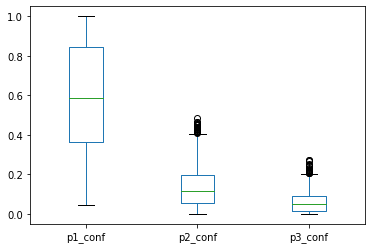

In [18]:
imgpred[['p1_conf', 'p2_conf', 'p3_conf']].plot(kind='box')

In [19]:
twtdata.sample(5)

,tweet_id,num_retweet,num_favorite
2330,666020888022790149,442,2340
785,772114945936949249,457,2666
1429,695629776980148225,1996,4378
499,810984652412424192,1391,5219
1355,701545186879471618,581,2562


In [20]:
twtdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tweet_id      2331 non-null   object
 1   num_retweet   2331 non-null   int64 
 2   num_favorite  2331 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 54.8+ KB


In [21]:
twtdata.describe()

,num_retweet,num_favorite
count,2331.000000,2331.000000
mean,2581.524239,7296.584728
std,4366.405524,11334.092658
min,1.000000,0.000000
25%,524.000000,1262.000000
50%,1204.000000,3161.000000
75%,2987.000000,8921.500000
max,74081.000000,150138.000000


In [22]:
twtdata[twtdata['num_favorite'] == 150138]

,tweet_id,num_retweet,num_favorite
1015,744234799360020481,74081,150138


<a id='issuesIII'></a>
#### Issues with The Tweet Data dataframe

1. Information about one type of observational unit (tweets) is spread across three different files/dataframes.

<a id='Clean'></a>
### Clean

<a id='Summary'></a>
#### Summary

 - ##### Quality Issues:
1. The $tweet\_id$ column in archive dataframe should be object (string) type;
2. The $timestamp$ column should be of datatime type;
3. There are 78 entries that are in reply to a status or a user - these should be removed together with the columns;
4. There are 181 entries that are retweets - these should be removed together with the columns;
5. The rating value columns are probably not accurate in the first place so need to be read in from text to double check;
6. There are a total of 14 rows that have multiple choices of Dogtionary, and these need to be corrected;
7. The $tweet\_id$ column in predictions dataframe should be Object (string) type;
8. There are 324 rows where none of the predicted breed is a dog's, and so need to drop these rows;
9. The three breed predictions along with the conf level and whether the breed is a dog need to be combined into one most likely dog breed.

 - ##### Tidiness Issues:
1. The four Dogtionary columns in archive dataframe can be merged into one;
2. Information about one type of observational unit (tweets) is spread across three different files/dataframes. Therefore all dataframes should be merged together.

<a id='Address'></a>
#### Addressing the Issues

In [23]:
twtarch_clean = twtarch.copy()
imgpred_clean = imgpred.copy()
twtdata_clean = twtdata.copy()

Quality issue 1 - The $tweet\_id$ column in archive dataframe should be object (string) type.

In [24]:
twtarch_clean['tweet_id'] = twtarch_clean['tweet_id'].astype('str')

Test the data type

In [25]:
twtarch_clean['tweet_id'].dtype

dtype('O')

Quality issue 2 - The $timestamp$ column should be of datatime type

In [26]:
twtarch_clean['timestamp'] = pd.to_datetime(twtarch_clean['timestamp'])

Test the data type

In [27]:
twtarch_clean['timestamp'].dtype

datetime64[ns, UTC]

Quality issue 3 - There are 78 entries that are in reply to a status or a user. These should be removed together with the columns.

In [28]:
twtarch_clean.drop(
    twtarch_clean[twtarch_clean['in_reply_to_status_id'].notnull()].index,
    inplace=True)
twtarch_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id'],
                   inplace=True,
                   axis=1)

Test to see if the entries have been removed

In [29]:
twtarch_clean.head(1)

,tweet_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


Quality issue 4 - There are 181 entries that are retweets. These should be removed together with the columns.

In [30]:
twtarch_clean.drop(
    twtarch_clean[twtarch_clean['retweeted_status_id'].notnull()].index,
    inplace=True)
twtarch_clean.drop([
    'retweeted_status_id', 'retweeted_status_user_id',
    'retweeted_status_timestamp'
],
                   inplace=True,
                   axis=1)
twtarch_clean.reset_index(inplace=True, drop=True)

Test to see the remaining data information

In [31]:
twtarch_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097 entries, 0 to 2096
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2097 non-null   object             
 1   timestamp           2097 non-null   datetime64[ns, UTC]
 2   source              2097 non-null   object             
 3   text                2097 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2097 non-null   int64              
 6   rating_denominator  2097 non-null   int64              
 7   name                2097 non-null   object             
 8   doggo               2097 non-null   object             
 9   floofer             2097 non-null   object             
 10  pupper              2097 non-null   object             
 11  puppo               2097 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(2

Quality issue 5 - The rating value columns are probably not accurate in the first place so need to be read in from text to double check.

In [32]:
new_cols = ['new_rating_numerator', 'new_rating_denominator']
twtarch_clean[new_cols] = twtarch_clean['text'].str.extract(
    '(\d*?\.?\d+)/(\d+)').astype('float')
twtarch_clean[new_cols] = twtarch_clean[new_cols].apply(
    lambda x: round(x).astype(int))

Test - check against original ratings for special cases

In [33]:
pd.set_option('display.max_colwidth', None)  # display full text
twtarch_clean.loc[twtarch_clean['rating_numerator'] > 20, [
    'text', 'rating_numerator', 'rating_denominator', 'new_rating_numerator',
    'new_rating_denominator'
]]

,text,rating_numerator,rating_denominator,new_rating_numerator,new_rating_denominator
339,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70,84,70
403,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7,24,7
528,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,10,10,10
586,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27,10,11,10
700,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150,165,150
770,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,1776,10,1776,10
904,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170,204,170
985,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50,50,50
1011,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90,99,90
1036,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80,80,80


In [34]:
# drop the original ratings columns also
twtarch_clean.drop(['rating_numerator', 'rating_denominator'],
                   axis=1,
                   inplace=True)

Quality issue 6 - There are a total of 14 rows that have multiple choices of Dogtionary, and these need to be corrected. But be mindful to leave out those that have two dogs (and indeed two stages / Dogtionary) in the image.

In [35]:
# Show text of those that have more than one Dogtionary for analysis in the next step
pd.set_option('display.max_colwidth', None)  # display full text
dogtionary_cols = ['doggo', 'floofer', 'pupper', 'puppo']
twtarch_clean[(twtarch_clean[dogtionary_cols].values == 'None').sum(
    axis=1) < 3]['text']

154          Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel
161    At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk
358    This is Dido. She's playing the lead role in "Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple." 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7
416                        Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho
446                        This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj
536    This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cau

In [36]:
twtarch_clean.loc[154, dogtionary_cols] = ['None', 'None', 'None', 'puppo']
twtarch_clean.loc[161, dogtionary_cols] = ['None', 'floofer', 'None', 'None']
twtarch_clean.loc[358, dogtionary_cols] = ['None', 'None', 'pupper', 'None']
twtarch_clean.loc[446, dogtionary_cols] = ['None', 'None', 'pupper', 'None']
twtarch_clean.loc[536, dogtionary_cols] = ['doggo', 'None', 'None', 'None']
twtarch_clean.loc[748, dogtionary_cols] = ['doggo', 'None', 'None', 'None']

Test to see if the multiple dog stage columns have been cleaned.

In [37]:
twtarch_clean[(twtarch_clean[dogtionary_cols].values == 'None').sum(
    axis=1) < 3]

,tweet_id,timestamp,source,text,expanded_urls,name,doggo,floofer,pupper,puppo,new_rating_numerator,new_rating_denominator
416,808106460588765185,2016-12-12 00:29:28+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho,https://twitter.com/dog_rates/status/808106460588765185/photo/1,None,doggo,None,pupper,None,12,10
562,781308096455073793,2016-09-29 01:42:20+00:00,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>","Pupper butt 1, Doggo 0. Both 12/10 https://t.co/WQvcPEpH2u",https://vine.co/v/5rgu2Law2ut,None,doggo,None,pupper,None,12,10
689,759793422261743616,2016-07-31 16:50:42+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll","https://twitter.com/dog_rates/status/759793422261743616/photo/1,https://twitter.com/dog_rates/status/759793422261743616/photo/1",Maggie,doggo,None,pupper,None,12,10
848,741067306818797568,2016-06-10 00:39:48+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC,https://twitter.com/dog_rates/status/741067306818797568/photo/1,just,doggo,None,pupper,None,12,10
897,733109485275860992,2016-05-19 01:38:16+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda",https://twitter.com/dog_rates/status/733109485275860992/photo/1,None,doggo,None,pupper,None,12,10


Quality issue 7 - The $tweet\_id$ column in predictions dataframe should be Object (string) type

In [38]:
imgpred_clean['tweet_id'] = imgpred_clean['tweet_id'].astype('str')

Test the data type

In [39]:
imgpred_clean['tweet_id'].dtype

dtype('O')

Quality issue 8 - There are 324 rows where none of the predicted breed is a dog's, and so need to drop these rows

In [40]:
imgpred_clean.drop(
    imgpred_clean[(imgpred_clean[['p1_dog', 'p2_dog', 'p3_dog']] == False).sum(
        axis=1) == 3].index,
    inplace=True)

Test to see if these rows have been removed

In [41]:
((imgpred_clean[['p1_dog', 'p2_dog',
                 'p3_dog']] == False).sum(axis=1) == 3).sum()

0

Quality issue 9 - The three breed predictions along with the conf level and whether the breed is a dog need to be combined into one most likely dog breed.

In [42]:
def pickbreed(row):
    if row['p1_dog']:
        return row['p1']
    elif row['p2_dog']:
        return row['p2']
    else:
        return row['p3']


# apply the function to get the most likely breed
imgpred_clean['breed'] = imgpred_clean.apply(pickbreed, axis=1)

Test to inspect a few sample rows to see if breed is correct

In [43]:
print(imgpred_clean[imgpred_clean.breed.isna() ==
                    True])  # check for error output
imgpred_clean.sample(5)

Empty DataFrame
Columns: [tweet_id, jpg_url, img_num, p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog, breed]
Index: []


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,breed
2056,888554962724278272,https://pbs.twimg.com/media/DFTH_O-UQAACu20.jpg,3,Siberian_husky,0.700377,True,Eskimo_dog,0.166511,True,malamute,0.111411,True,Siberian_husky
821,693095443459342336,https://pbs.twimg.com/media/CZ5entwWYAAocEg.jpg,1,ice_lolly,0.660099,False,neck_brace,0.039563,False,Yorkshire_terrier,0.033488,True,Yorkshire_terrier
1201,741067306818797568,https://pbs.twimg.com/media/CkjMx99UoAM2B1a.jpg,1,golden_retriever,0.843799,True,Labrador_retriever,0.052956,True,kelpie,0.035711,True,golden_retriever
128,668274247790391296,https://pbs.twimg.com/media/CUYv4d2WUAAziXs.jpg,1,soft-coated_wheaten_terrier,0.406374,True,Lakeland_terrier,0.263854,True,toy_poodle,0.150844,True,soft-coated_wheaten_terrier
47,666817836334096384,https://pbs.twimg.com/media/CUEDSMEWEAAuXVZ.jpg,1,miniature_schnauzer,0.496953,True,standard_schnauzer,0.285276,True,giant_schnauzer,0.073764,True,miniature_schnauzer


In [44]:
# drop the original breed prediction columns also
imgpred_clean.drop([
    'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
    'p3_dog'
],
                   axis=1,
                   inplace=True)

Tidiness issue 1 - the dog stage is one variable and hence should form single column. So the four Dogtionary columns in archive dataframe can be merged into one single column.

In [45]:
twtarch_clean[dogtionary_cols] = twtarch_clean[dogtionary_cols].replace(
    'None', np.nan)


# define a function to pick (or combine where applicable) the right dogtionary
def pickdogtionary(row):
    if row[dogtionary_cols].isna().sum() == 4:
        return 'None'
    else:
        return ' & '.join(row[dogtionary_cols][row[dogtionary_cols].notna()])


# apply the function
twtarch_clean['dogtionary'] = twtarch_clean[dogtionary_cols].apply(
    pickdogtionary, axis=1)

Test the Dogtionary for three distinct scenarios

In [46]:
twtarch_clean.loc[
    [1, 446, 897],
    ['text', 'doggo', 'floofer', 'pupper', 'puppo', 'dogtionary']]

,text,doggo,floofer,pupper,puppo,dogtionary
1,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,NaN,None
446,This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj,NaN,NaN,pupper,NaN,pupper
897,"Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda",doggo,NaN,pupper,NaN,doggo & pupper


In [47]:
# drop the original dogtionary columns also
twtarch_clean.drop(dogtionary_cols, axis=1, inplace=True)

Tidiness issue 2 - Information about one type of observational unit (tweets) is spread across three different files/dataframes. Therefore all dataframes should be merged together.

In [48]:
twtarch_master = pd.merge(twtarch_clean, imgpred_clean, on='tweet_id')
twtarch_master = pd.merge(twtarch_master, twtdata_clean, on='tweet_id')

Test to see the final master dataframe information

In [49]:
twtarch_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1659 entries, 0 to 1658
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   tweet_id                1659 non-null   object             
 1   timestamp               1659 non-null   datetime64[ns, UTC]
 2   source                  1659 non-null   object             
 3   text                    1659 non-null   object             
 4   expanded_urls           1659 non-null   object             
 5   name                    1659 non-null   object             
 6   new_rating_numerator    1659 non-null   int64              
 7   new_rating_denominator  1659 non-null   int64              
 8   dogtionary              1659 non-null   object             
 9   jpg_url                 1659 non-null   object             
 10  img_num                 1659 non-null   int64              
 11  breed                   1659 non-null   obj

<a id='partII'></a>
## Part II - Analysis and Insight

In [50]:
twtarch_master.to_csv('twitter_archive_master.csv', index=False)

In [51]:
pd.read_csv('twitter_archive_master.csv').sample(5)

,tweet_id,timestamp,source,text,expanded_urls,name,new_rating_numerator,new_rating_denominator,dogtionary,jpg_url,img_num,breed,num_retweet,num_favorite
643,749395845976588288,2016-07-03 00:14:27+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is George. He just remembered that bees are dying globally at an alarming rate. Scary stuff George. 10/10 https://t.co/lznl6QGkYc,"https://twitter.com/dog_rates/status/749395845976588288/photo/1,https://twitter.com/dog_rates/status/749395845976588288/photo/1",George,10,10,None,https://pbs.twimg.com/media/CmZjizYW8AA3FCN.jpg,1,Pomeranian,3291,8276
946,700864154249383937,2016-02-20 02:06:50+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","""Pupper is a present to world. Here is a bow for pupper."" 12/10 precious as hell https://t.co/ItSsE92gCW",https://twitter.com/dog_rates/status/700864154249383937/photo/1,a,12,10,pupper,https://pbs.twimg.com/media/Cbn4OqKWwAADGWt.jpg,1,kuvasz,598,2493
1215,678774928607469569,2015-12-21 03:12:08+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Tug. He's not required to wear the cone he just wants his voice to project more clearly. 11/10 https://t.co/Sp739Ou2qx,https://twitter.com/dog_rates/status/678774928607469569/photo/1,Tug,11,10,None,https://pbs.twimg.com/media/CWt-MNIWEAAUC9S.jpg,1,Pembroke,855,2678
1288,675781562965868544,2015-12-12 20:57:34+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to Buddah. He was Waldo for Halloween. 11/10 https://t.co/DVAqAnb624,https://twitter.com/dog_rates/status/675781562965868544/photo/1,Buddah,11,10,None,https://pbs.twimg.com/media/CWDbv2yU4AARfeH.jpg,1,Maltese_dog,436,1517
925,703769065844768768,2016-02-28 02:29:55+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you're trying to watch your favorite tv show but your friends keep interrupting. 10/10 relatable af https://t.co/QQZDCYl6zT,"https://twitter.com/dog_rates/status/703769065844768768/photo/1,https://twitter.com/dog_rates/status/703769065844768768/photo/1",None,10,10,None,https://pbs.twimg.com/media/CcRKOzyXEAQO_HN.jpg,2,boxer,1087,3127


The most common Dogtionary type is - this is found to be pupper.

In [52]:
twtarch_master['dogtionary'].value_counts()

None              1403
pupper             168
doggo               54
puppo               22
floofer              8
doggo & pupper       4
Name: dogtionary, dtype: int64

The most common dog breed is - this is found to be golden retriever, followed by Labrador retriever.

In [53]:
twtarch_master['breed'].value_counts()

golden_retriever        156
Labrador_retriever      104
Pembroke                 94
Chihuahua                90
pug                      62
                       ... 
Bouvier_des_Flandres      1
standard_schnauzer        1
Irish_wolfhound           1
Japanese_spaniel          1
silky_terrier             1
Name: breed, Length: 113, dtype: int64

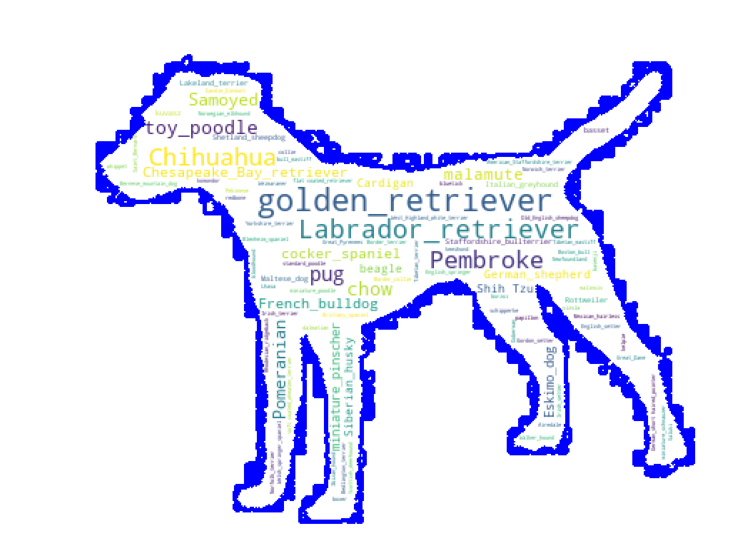

In [54]:
# show the popular breeds in a word cloud in a dog shaped contour
plt.figure(figsize=(14, 10))

dog_mask = np.array(Image.open("dog.jpg"))
wordcloud_breed = WordCloud(background_color="white",
                            mask=dog_mask,
                            width=800,
                            height=400,
                            contour_width=3,
                            contour_color='blue').generate(' '.join(
                                twtarch_master['breed']))
plt.imshow(wordcloud_breed)
plt.axis("off")
plt.show()

Percentage of times a dog has been scored at or above 10, i.e., these dog owners must be beyond impressed with their dogs - this is found to be over 82%, or in other words, a large majority.

In [55]:
(twtarch_master['new_rating_numerator'] >= 10).sum() / len(twtarch_master)

0.8239903556359253

The dog breed that has the highest average number of retweets - this is found to be Bedlington terrier, followed by Afghan hound and standard poodle.

In [56]:
twtarch_master.groupby('breed').mean()['num_retweet'].sort_values(
    ascending=False)

breed
Bedlington_terrier    6990.166667
Afghan_hound          4980.333333
standard_poodle       4674.545455
French_bulldog        4598.100000
English_springer      4583.900000
                         ...     
EntleBucher            585.000000
Tibetan_terrier        464.250000
Japanese_spaniel       376.000000
Brabancon_griffon      242.333333
groenendael            234.000000
Name: num_retweet, Length: 113, dtype: float64

The dog breed that received the highest average number of favorites - this is found to be Bedlington terrier, followed by Saluki and French_bulldog.

In [57]:
twtarch_master.groupby('breed').mean()['num_favorite'].sort_values(
    ascending=False)

breed
Bedlington_terrier      22320.833333
Saluki                  21506.250000
French_bulldog          18132.200000
Bouvier_des_Flandres    15916.000000
Afghan_hound            15224.000000
                            ...     
Tibetan_terrier          1620.500000
Irish_wolfhound          1333.000000
Japanese_spaniel         1165.000000
groenendael              1015.000000
Brabancon_griffon         773.333333
Name: num_favorite, Length: 113, dtype: float64

So, it appears that Bedlington terrier is the highest retweeted & thumbed-up dog breed. Other dog breeds such as Afghan hound and French bulldog are also much liked on Twitter.

Is there a correlation between number of retweet and number of favorite? - this is found to be yes and there is quite a strong positive relationship.

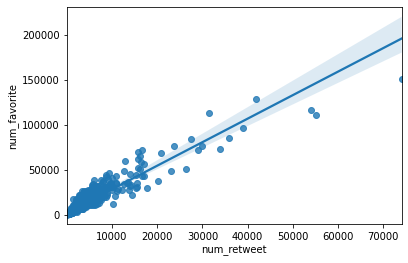

In [58]:
# visualise with a regression plot
sns.regplot(x=twtarch_master['num_retweet'], y=twtarch_master['num_favorite'])
plt.show()

In [59]:
# find out the pearson r value and the corresponding p-value
stats.pearsonr(twtarch_master['num_retweet'], twtarch_master['num_favorite'])

(0.9304677360103853, 0.0)

A positive close-to-one coefficient with a very small p-value signifies a strong positive correlation between number of retweet and favorite ratings, which is as expected.

In [60]:
# The time period of this data
twtarch_master['timestamp'].min(), twtarch_master['timestamp'].max()

(Timestamp('2015-11-15 22:32:08+0000', tz='UTC'),
 Timestamp('2017-08-01 00:17:27+0000', tz='UTC'))